# <center> Projet 6 : Classifiez automatiquement des biens de consommation
    Notebook Données images

**Introduction**

Ce Notebook traite les images avec les méthodes classiques et de deep Learning avec classification non supervisée et classification supervisée.

Nous avons la mission suivante :

* Afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF.
* Un algorithme de type CNN Transfer Learning peut éventuellement être utilisé.


# 1. Importation des modules et données

In [1]:
!pip install tensorflow

In [2]:
!pip install opencv-contrib-python

In [3]:
!pip install imutils

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from os import listdir

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering


from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
from PIL import Image as Image_PIL
import imageio
import imutils

import time


In [5]:
pd.options.display.max_rows = 999

In [6]:
#upload images
image_path="C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images"
images = [cv2.imread(file) for file in listdir(image_path)]
print(len(images))

1050


In [7]:
from IPython.display import Image

images_list =[Image(file) for file in listdir(image_path)]
len(images_list)

1050

In [8]:
data = pd.read_csv('C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\flipkart_com-ecommerce_sample_1050.csv')

In [9]:
data.shape

(1050, 15)

# 2. Prétraitement des données visuelles

###  2.1 Categories

In [10]:
data['product_category_tree'].nunique()

642

In [11]:
# Sample checking

data['product_category_tree'][100]

'["Beauty and Personal Care >> Makeup >> Vanity Boxes >> Goldencollections Vanity Boxes"]'

La variable product_category_tree est constituée de plusieurs sous-catégories de produits séparées par des chevrons.

Exemple : Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...

In [12]:
#Traitement des catégories
def split_categories(category, level):
    '''Fonction qui affiche les '''
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_categories(category,0)
def split_categories_2(category):
    return split_categories(category,1)
def split_categories_3(category):
    return split_categories(category,2)

def All_categories(dataframe):
    dataframe['cat_Niv_1'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['cat_Niv_2'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['cat_Niv_3'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [13]:
data = All_categories(data)

In [14]:
data.groupby('cat_Niv_1').count()['uniq_id']

cat_Niv_1
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150
Name: uniq_id, dtype: int64

In [15]:
data['cat_Niv_1']
data['image']

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

In [16]:
df_Pict=data[['cat_Niv_1','image']]

In [17]:
df_Pict['image']

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

In [18]:
df_Pict=df_Pict.rename(columns = {'cat_Niv_1':'Category'})

In [19]:
df_Pict

,Category,image
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg
...,...,...
1045,Baby Care,958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046,Baby Care,fd6cbcc22efb6b761bd564c28928483c.jpg
1047,Baby Care,5912e037d12774bb73a2048f35a00009.jpg
1048,Baby Care,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg


In [20]:
#Identification des catégories les moins représentées
occurence_cat = pd.DataFrame(data['cat_Niv_1'].value_counts())

In [21]:
occurence_cat.head()

,cat_Niv_1
Kitchen & Dining,150
Baby Care,150
Computers,150
Home Decor & Festive Needs,150
Beauty and Personal Care,150


In [22]:
#data.to_csv('data_saved_data_categories.csv',sep=',',index = True)

### 2.2 Prétraitement

- **PILS** (Pyhton Imaging Library) et **OpenCV** (Open Compute Vision) sont des librairies qui comprennent un ensemble de méthodes permettant de charger, traiter les images (redimensionnement, filtres...).
- Ces librairies seront utilisées pour le pré-traitement des images.

- Le traitement sera effectué en 4 étapes :
    - Réduction du bruit,
    - égalisation de l'histogramme,
    - conversion de RGB (couleurs vraies) en niveaux de gris (pour Sift),
    - redimensionnement en 128 * 128.


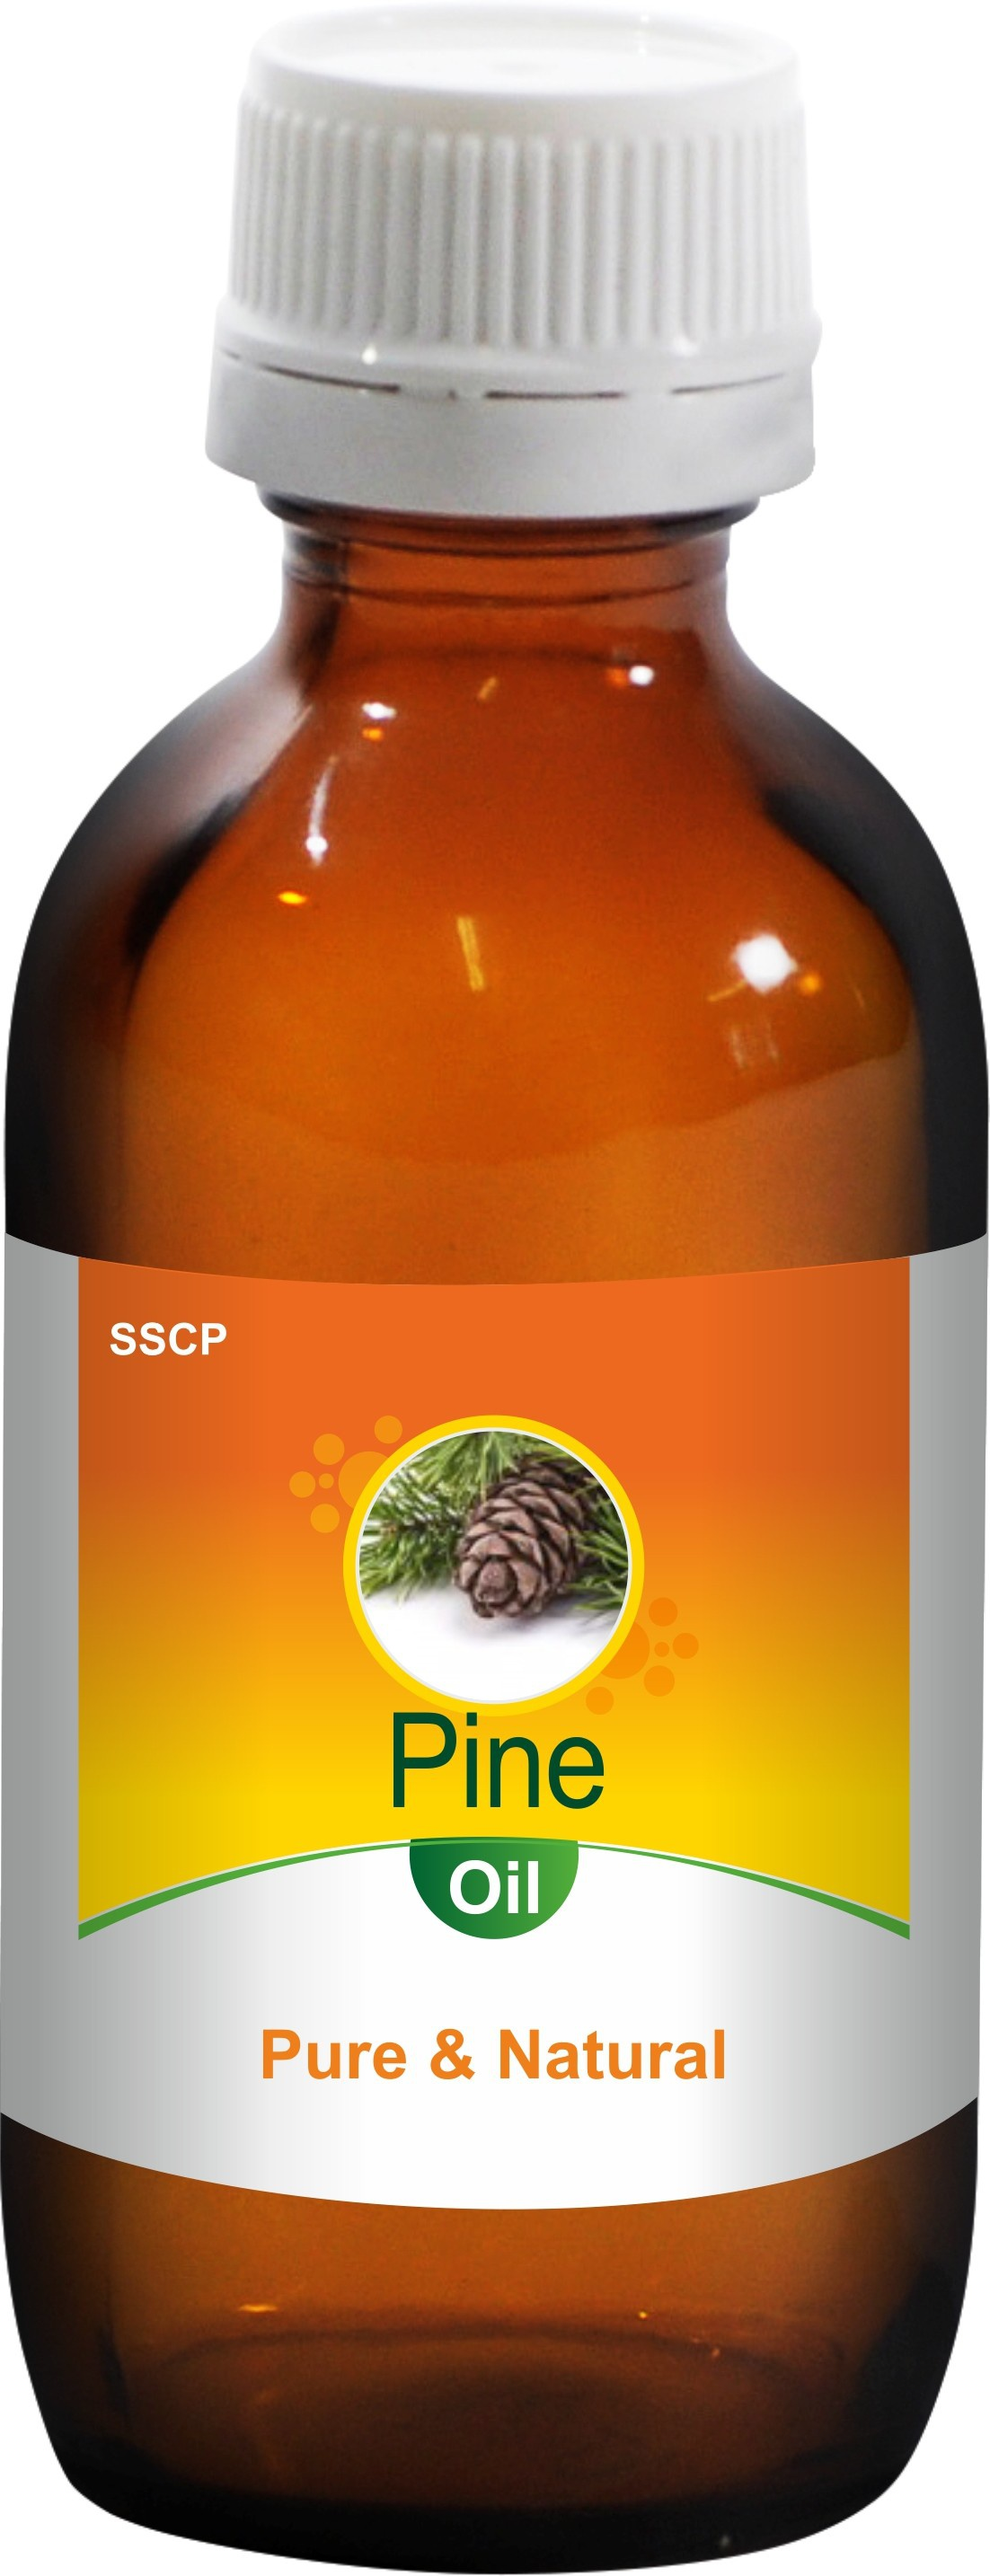

In [23]:
from IPython.display import Image
Image("C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images\\"+ str(data.sample(1)['image'].values.tolist()[0]), width=100 )

In [24]:
#Echantillon de données
img_echantillon = data.sample(1050, random_state=42)

In [25]:
img_echantillon 

,uniq_id,crawl_timestamp,product_url,product_name,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,cat_Niv_1,cat_Niv_2,cat_Niv_3
352,833a87b0af3b84fe246d2ebf271af177,2015-12-01 06:13:00 +0000,http://www.flipkart.com/zyxel-pla-4205/p/itmdy...,Zyxel PLA-4205,RTRDYZYDXGHXXJNZ,10999.0,8100.0,833a87b0af3b84fe246d2ebf271af177.jpg,False,Buy Zyxel PLA-4205 only for Rs. 8100 from Flip...,No rating available,No rating available,Zyxel,"{""product_specification""=>[{""key""=>""In The Box...",Computers,Network Components,Routers
689,55195de3873fffaa9e37b041533d7305,2015-12-31 09:19:31 +0000,http://www.flipkart.com/philips-9-5-w-led-b22-...,Philips 9.5 W LED B22 3000K A55 IND Bulb,BLBEF3HEKYURWHKG,699.0,419.0,55195de3873fffaa9e37b041533d7305.jpg,False,Buy Philips 9.5 W LED B22 3000K A55 IND Bulb f...,No rating available,No rating available,Philips,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Kitchen & Dining,Lighting,Bulbs
485,44b963eb856b4831dfdd21b666593c95,2016-01-07 05:50:25 +0000,http://www.flipkart.com/lapguard-lenovo-ideapa...,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,ACCDVPGKY3GBDB5P,3999.0,1799.0,44b963eb856b4831dfdd21b666593c95.jpg,False,Lapguard Lenovo IdeaPad V470 6 Cell Laptop Bat...,2,2,Lapguard,"{""product_specification""=>[{""key""=>""In The Box...",Computers,Laptop Accessories,Batteries
388,98ad5b99ad96695568d8f143b11ab740,2015-12-01 06:13:00 +0000,http://www.flipkart.com/anna-andre-paris-set-d...,Anna Andre Paris Set of Dark Fire & Numero 1 D...,CAGEYUXVZSFVZRHE,355.0,310.0,98ad5b99ad96695568d8f143b11ab740.jpg,False,Flipkart.com: Buy Anna Andre Paris Set of Dark...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Number of ...",Beauty and Personal Care,Fragrances,Deodorants
31,29b1ca231e10d5269516b80bf9d0dffc,2015-12-04 07:25:36 +0000,http://www.flipkart.com/lenco-bdblue-tango-ana...,"Lenco Bdblue Tango Analog Watch - For Men, Boys",WATEB2FZUMQU4W7R,1499.0,599.0,29b1ca231e10d5269516b80bf9d0dffc.jpg,False,"Lenco Bdblue Tango Analog Watch - For Men, Bo...",No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",Watches,Wrist Watches,Lenco Wrist Watches
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,394c2c627914e1eed9b8ac343583a679,2015-12-01 06:13:00 +0000,http://www.flipkart.com/asus-rt-n12-lx-300mbps...,Asus RT-N12 LX 300Mbps Wireless Router,RTRD6352VX7RZSWG,3950.0,1990.0,394c2c627914e1eed9b8ac343583a679.jpg,False,Buy Asus RT-N12 LX 300Mbps Wireless Router onl...,4.1,4.1,Asus,"{""product_specification""=>[{""key""=>""Firewall"",...",Computers,Network Components,Routers
466,3bc98543c7dd0d8fce5b8185b4a58c43,2016-05-05 06:42:02 +0000,http://www.flipkart.com/shaun-printed-baby-boy...,"Shaun Printed Baby Boy's Yellow, Grey, Black T...",TKPEGRKHT4832GFE,2999.0,1106.0,3bc98543c7dd0d8fce5b8185b4a58c43.jpg,False,Key Features of Shaun Printed Baby Boy's Yello...,No rating available,No rating available,Shaun,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Infant Wear,Baby Boys' Clothes
121,7dd5e83e2108a97659577e50879f9d9f,2016-03-25 17:27:56 +0000,http://www.flipkart.com/toffyhouse-baby-boy-s-...,Toffyhouse Baby Boy's Sleepsuit,BOLEDTCXKEZP9MVG,545.0,545.0,7dd5e83e2108a97659577e50879f9d9f.jpg,False,Specifications of Toffyhouse Baby Boy's Sleeps...,No rating available,No rating available,Toffyhouse,"{""product_specification""=>[{""key""=>""Sleeve"", ""...",Baby Care,Infant Wear,Baby Boys' Clothes
1044,be0f39341d771aac57084970f1ed6425,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Stickers Sticker,STIE9F5UYBHF4MXU,1429.0,1143.0,be0f39341d771aac57084970f1ed6425.jpg,False,Buy Wallmantra Medium Vinyl Stickers Sticker f...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,Baby & Kids Gif

In [26]:
img_echantillon['image'] = img_echantillon['image'].apply(lambda x: 'C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images\\'+str(x))

In [27]:
img_echantillon['image'].head(1)

352    C:\Users\Marwa\Downloads\Projet_6\Dataset+proj...
Name: image, dtype: object

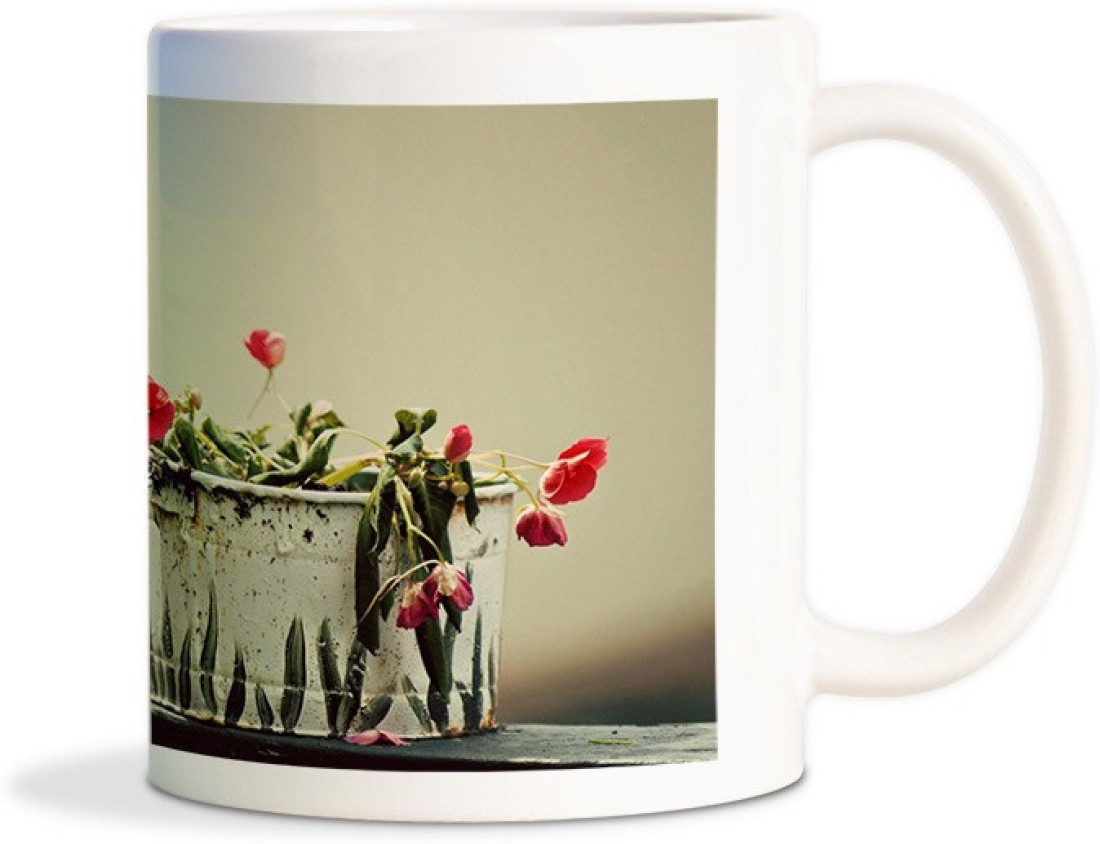

In [28]:
Image(img_echantillon.iloc[30]['image'], width=150)

In [29]:
img_echantillon.iloc[30]

uniq_id                                     feefbdff924dd6b7cc266449c9a36d69
crawl_timestamp                                    2015-12-01 12:40:44 +0000
product_url                http://www.flipkart.com/rockmantra-red-flowers...
product_name                    Rockmantra Red Flowers In Bucket Ceramic Mug
pid                                                         MUGEAGGKMUGXQ2YH
retail_price                                                           499.0
discounted_price                                                       199.0
image                      C:\Users\Marwa\Downloads\Projet_6\Dataset+proj...
is_FK_Advantage_product                                                False
description                Rockmantra Red Flowers In Bucket Ceramic Mug (...
product_rating                                           No rating available
overall_rating                                           No rating available
brand                                                                    NaN

### 2.3 Essai de convolution

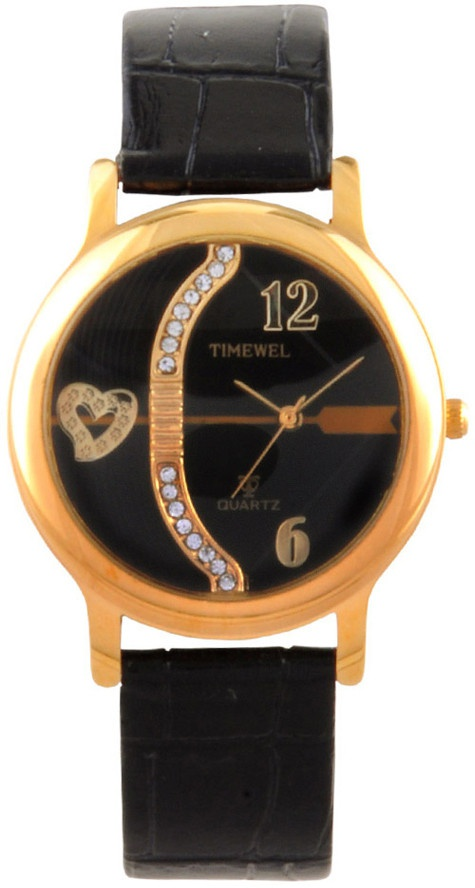

In [30]:
display(Image('C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images\\9d2d833bf63095902417c2a35f72432a.jpg', width=200))

In [31]:
img_conv = Image_PIL.open('C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images\\19a570b6717955a8c48e5f280617ef24.jpg')

In [32]:
img_conv = np.array(img_conv)

In [33]:
img_conv = cv2.resize(img_conv, (200,200))

In [34]:
def filtre_moyenneur(img, voisinage = 1):
    '''Remplace chaque pixel par l\'intensité moyenne de son voisinage'''
    etendue = 1+2*voisinage
    img2 = np.copy(img)
    
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if (i<voisinage)|(i>img.shape[0] - voisinage-1):
                img2[i,j] = int(255/2)
            if (j<voisinage)|(j>img.shape[0] - voisinage-1):
                img2[i,j] = int(255/2)
            
            
    for i in range(voisinage,img.shape[0]-voisinage):
        for j in range(voisinage,img.shape[1]-voisinage):
            mean = 0
            for mean_x in range(i-voisinage, i+voisinage+1):
                for mean_y in range(j-voisinage, j+voisinage+1):
                    mean += img[mean_x, mean_y]
            img2[i,j] = mean/(etendue**2)
    
    
    return img2  

In [35]:
img_conv_traitee_1 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=1)
img_conv_traitee_2 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=2)
img_conv_traitee_3 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=3)
img_conv_traitee_4 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=4)


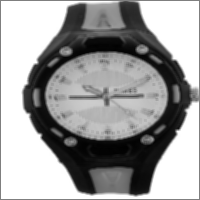

In [36]:
Image_PIL.fromarray(img_conv_traitee_1)

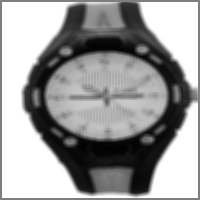

In [37]:
Image_PIL.fromarray(img_conv_traitee_2)

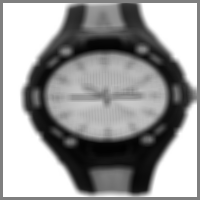

In [38]:
Image_PIL.fromarray(img_conv_traitee_3)

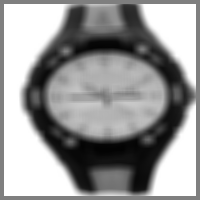

In [39]:
Image_PIL.fromarray(img_conv_traitee_4)

**Réduction de bruit**

- On observe l'apparition d'un bruit qui se rapproche du gaussien : apparition de carré gris.
- Pour améliorer la qualité des images, 3 filtres différents sont habituellement testés :
    - un **filtre gaussien**filtre linéaire dont les éléments du noyau de convolution sont déterminés selon la densité d'une loi gaussienne centrée à 2 dimensions),
    - un **filtre par lissage par moyennage** la valeur de chaque pixel est remplacée par la moyenne de son voisinage),
    - ou un **filtre par lissage médian** (la valeur de chaque pixel est remplacée par la médiane de son voisinage).
    - ou avec un algorithme **Non-local Means Denoising**

In [40]:
im = np.array(Image_PIL.open(img_echantillon.iloc[30]['image']))

In [41]:
im = gaussian_filter(im, sigma=3)

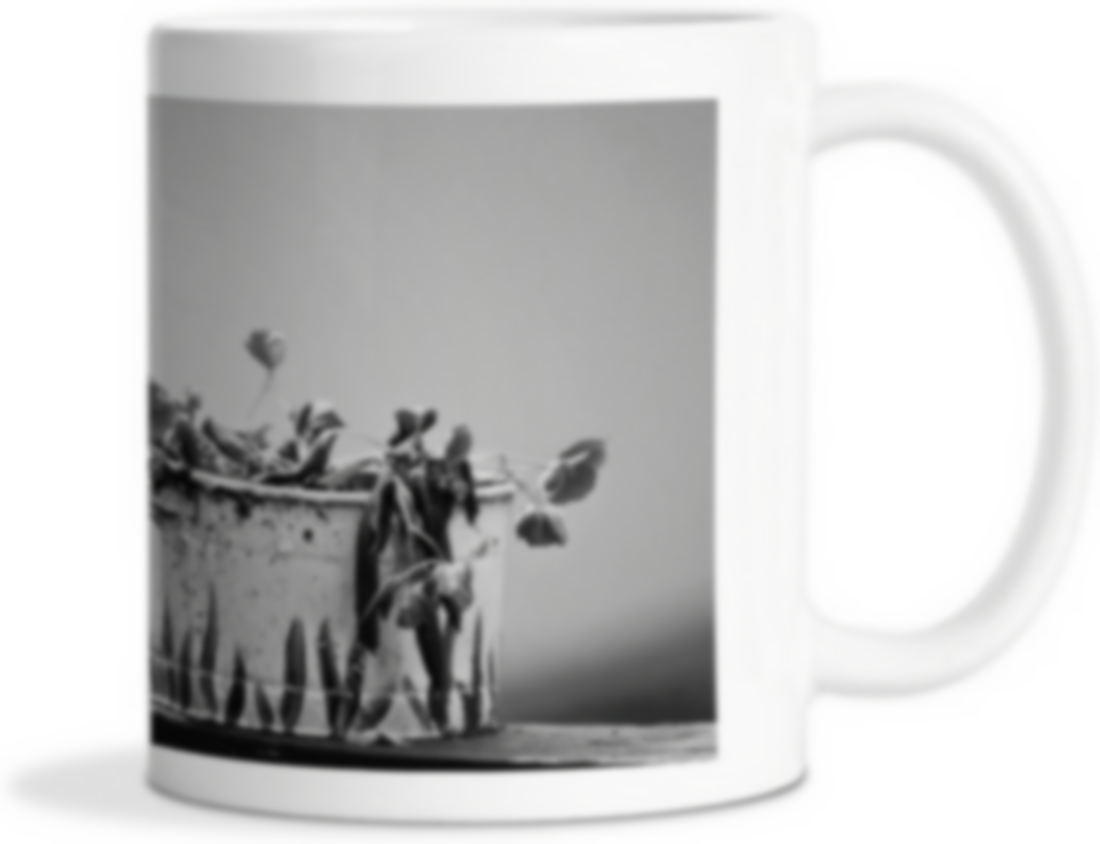

In [42]:
Image_PIL.fromarray(im)

**Egalisation**

In [43]:
hist, bins = np.histogram(im.flatten(), 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

In [44]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

In [45]:
im2=cdf[im]

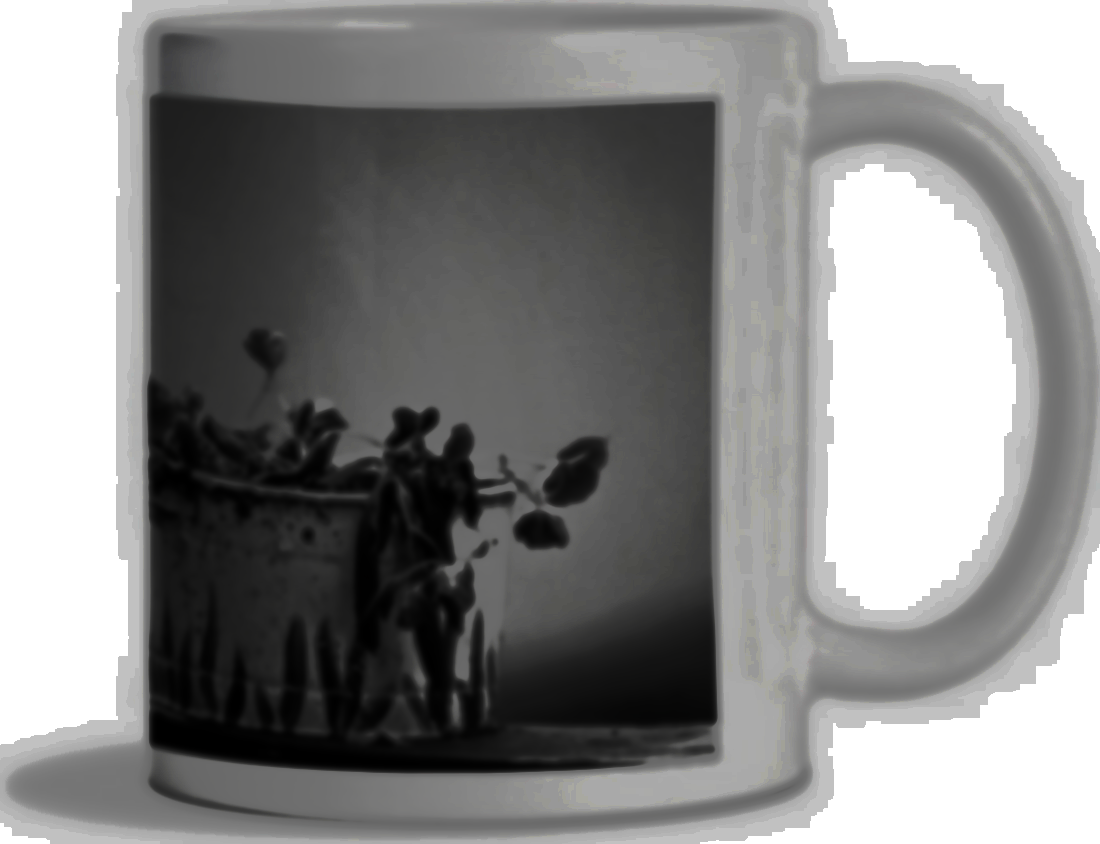

In [46]:
Image_PIL.fromarray(im2)

In [47]:
img3 = cv2.imread(img_echantillon.iloc[12]['image'],0)
equ = cv2.equalizeHist(img3)
res = np.hstack((img3,equ)) 

**Redimensionnement**

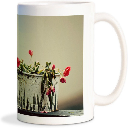

In [48]:
resize_img = cv2.resize(np.array(Image_PIL.open(img_echantillon.iloc[30]['image'])), dsize=(128,128))
Image_PIL.fromarray(resize_img)

**Bilan**

Suite aux différents tests réalisés avec OpenCv, le pré-traitement suivant sera appliqué sur toutes les images :
-  Correction du contraste (égalisation d'histogramme) avec OpenCV.
-  Réduction du bruit avec le filtre gaussian d'OpenCV.
-  Conversion en niveau de gris de l'image (SIFT...).
-  Réduction de dimension avec OpenCV (resize 128 * 128).

### 2.4 Fonction de prétraitement

In [49]:
def preprocess(image, path=False):
    '''prétraitement des images'''
    
    #ouverture du fichier
    if path == False: #si on a fourni un array en entree :
        im = image
    else: #si on a fourni un chemin vers le fichier en entree:
        im = np.array(Image_PIL.open(image))
    
    #greyscale
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #flou gaussien
    #im = gaussian_filter(im, sigma=2)
    
    #égalisation
    im = cv2.equalizeHist(im)
    
    #Redimensionnement
    im =  cv2.resize(np.array(im), dsize=(128,128)) #ça change pas le nombre des pixels dans l'image
    
    return im

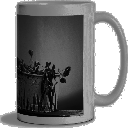

In [50]:
Image_PIL.fromarray(preprocess(img_echantillon.iloc[30]['image'], path=True))

In [51]:
img_echantillon.iloc[30]['image']

'C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images\\feefbdff924dd6b7cc266449c9a36d69.jpg'

In [52]:
import os

In [53]:
path = 'C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images\\'
os.path.join(path, "2c475daafe597ed93c1e27fcaa38d8cc.jpg")

'C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Images\\2c475daafe597ed93c1e27fcaa38d8cc.jpg'

In [54]:
data['image'].apply(lambda x: preprocess(os.path.join(path, "2c475daafe597ed93c1e27fcaa38d8cc.jpg"), path=True))

0       [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1       [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
2       [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
3       [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
4       [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
                              ...                        
1045    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1046    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1047    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1048    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
1049    [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
Name: image, Length: 1050, dtype: object

In [55]:
# Pré-traitement de toutes les images
data['image_proces'] = data['image'].apply(lambda x: preprocess(os.path.join(path, x), path=True))

C:\Users\Marwa\anaconda3\lib\site-packages\PIL\Image.py:2855: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [56]:
data['image_proces']

0       [[209, 209, 211, 209, 208, 209, 208, 208, 210,...
1       [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
2       [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
3       [[255, 255, 255, 255, 255, 255, 255, 255, 255,...
4       [[155, 195, 184, 180, 155, 73, 168, 177, 182, ...
                              ...                        
1045    [[245, 251, 255, 247, 253, 253, 251, 249, 254,...
1046    [[250, 250, 250, 250, 246, 247, 247, 251, 247,...
1047    [[255, 255, 255, 255, 163, 255, 255, 255, 255,...
1048    [[39, 38, 26, 20, 43, 24, 47, 36, 26, 42, 23, ...
1049    [[240, 240, 240, 240, 240, 240, 240, 240, 240,...
Name: image_proces, Length: 1050, dtype: object

In [60]:
#enregistrer les images prétraités csv
data.to_csv('C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Imag_preprocess.csv')

In [64]:
data['image']

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

# 3. Extraction des features (SIFT)

- SIFT (Scale Invariant Feature Transform),  cette méthode, développée en 1999 et très populaire dans le domaine de la vision par ordinateur, permet d'extraire des features (ou points d'intérêt) de l'image et de calculer leurs descripteurs. 
- L'algorithme SIFT se divise en plusieurs étapes :
    - Détection : création de l'espace des échelles, calcul des "DoG" (Différence of Gaussian), localisation des points d'intérêt.
    - Description : assignation d'orientation, création des descripteurs.

In [66]:
data_process = 'C:\\Users\\Marwa\\Downloads\\Projet_6\\Dataset+projet+prétraitement+textes+images\\Flipkart\\Imag_preprocess.csv'

In [68]:
i = np.random.randint(img_echantillon.shape[0]-1)

In [69]:
img_sift = preprocess(img_echantillon.iloc[30]['image'], path=True)

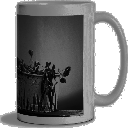

In [70]:
Image_PIL.fromarray(img_sift)

In [71]:
cv2.ocl.setUseOpenCL(False)

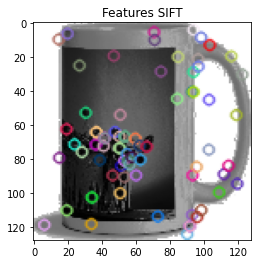

In [72]:
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(img_sift,None)
img=cv2.drawKeypoints(img_sift,kp,img_sift)

plt.figure(figsize=(4,4))
plt.title('Features SIFT')
plt.imshow(img)

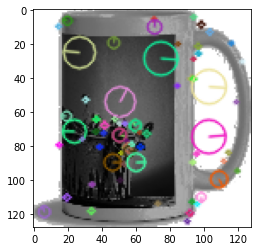

In [73]:
img=cv2.drawKeypoints(img_sift,kp,img_sift,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(4,4))
plt.imshow(img)

## 3.1 Détermination et affichage des descripteurs SIFT

* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [74]:
def get_files(path_list):
    '''Renvoie la liste des matrices d'images'''
    liste_image = []
    compteur = 0
    for image_path in path_list:
        #im = cv2imread(image_path, 0)
        im = np.array(Image_PIL.open(image_path))
        liste_image.append(im)
        compteur +=1
    return liste_image

In [75]:
def create_features():
    return cv2.SIFT_create()
    
def features(sift, image):
    keypoints,descripteurs = sift.detectAndCompute(image,None)
    return [keypoints, descripteurs]

def Sift_feature(image):
    '''traitement complet d'une image'''
    
    sift = create_features()
    image = preprocess(image, path=False)
    keypoints, descripteurs = features(sift, image)
    return keypoints, descripteurs

In [76]:
j=0

echantillon = get_files(img_echantillon['image'].tolist())

keypoints = []
descripteurs = []


for array_image in echantillon:
    j+=1
    kea,des = Sift_feature(array_image)
    keypoints.append(kea)
    descripteurs.append(des)

In [77]:
print(len(descripteurs))
print(descripteurs[0].shape)

1050
(36, 128)


In [78]:
descripteurs_vstacked = np.vstack(descripteurs)
print(descripteurs_vstacked.shape)

(131617, 128)


In [79]:
descripteurs[0]

array([[ 0., 24., 14., ...,  0.,  0.,  1.],
       [ 0., 66., 27., ...,  1.,  0.,  1.],
       [ 0., 71., 30., ...,  3.,  0.,  1.],
       ...,
       [77.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0., 27., 51., ...,  0.,  0., 22.],
       [10.,  0.,  0., ...,  0.,  2., 28.]], dtype=float32)

## 3.2 Création des clusters de descripteurs

* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [80]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics

In [81]:
# Determination number of clusters
k = int(round(np.sqrt(len(descripteurs_vstacked)),0))
print('Nombre de clusters estimé:', k)

Nombre de clusters estimé: 363


In [82]:
# Clustering
kmeans = MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=42)
kmeans.fit(descripteurs_vstacked)

C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1043: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


MiniBatchKMeans(init_size=1089, n_clusters=363, random_state=42)

## 3.3 Création des features des images

* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [83]:
def Image_Hist(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("Erreur : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [84]:
# Matrice des histogrammes
hist_vectors=[]

for i, image_desc in enumerate(descripteurs) :
    if i%100 == 0 : print(i)  
    hist = Image_Hist(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

img_features = np.asarray(hist_vectors)
print()
print("features :",img_features)

0
100
200
300
400
500
600
700
800
900
1000

features : [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.01612903 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.0137931  0.00689655 0.02068966 ... 0.         0.         0.        ]]


## 3.4 Réduction de dimension

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [85]:
from sklearn import manifold, decomposition

print("Dimensions avant PCA :", img_features.shape)
pca= decomposition.PCA(n_components=0.99)
pca_feat= pca.fit_transform(img_features)
print("Dimensions après PCA :", pca_feat.shape)

Dimensions avant PCA : (1050, 363)
Dimensions après PCA : (1050, 327)


#### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [86]:
#TSNE
tsne = manifold.TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(pca_feat)
df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['TSNE-1', 'TSNE-2'])
df_tsne["class"] = df_Pict["Category"]
print(df_tsne.shape)

C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Marwa\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(1050, 3)


In [87]:
df_tsne.head()

,TSNE-1,TSNE-2,class
0,13.565564,-4.611577,Home Furnishing
1,-1.756924,-11.182927,Baby Care
2,-16.650814,-8.138680,Baby Care
3,8.445465,1.279152,Home Furnishing
4,-2.797162,-8.860839,Home Furnishing


## 3.5 Analyse visuelle : affichage T-SNE selon catégories d'images

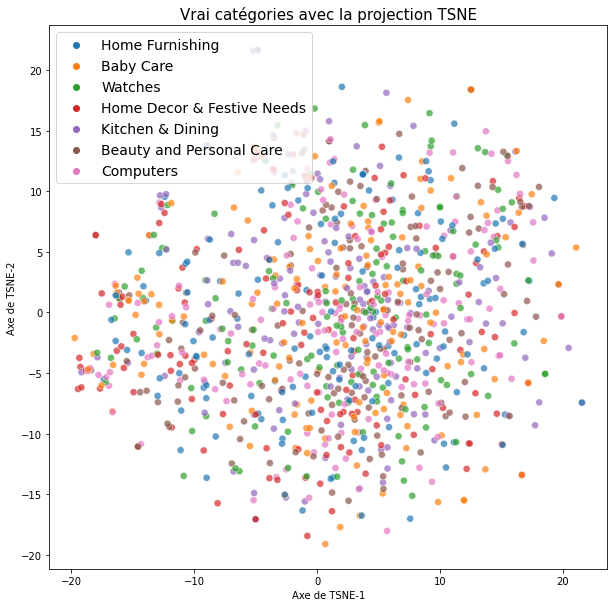

In [88]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="TSNE-1", y="TSNE-2", hue="class", data=df_tsne, s=50, alpha=0.7,palette=sns.color_palette("tab10", 7))
plt.title('Vrai catégories avec la projection TSNE', fontsize = 15)
plt.xlabel('Axe de TSNE-1', fontsize = 10)
plt.ylabel('Axe de TSNE-2', fontsize = 10)
plt.legend(prop={'size': 14})

# plt.ylim(-15, 15)
# plt.xlim(-15, 15)

plt.show()

## 3.6 Analyse mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [89]:
from sklearn import cluster, metrics

Clusters = cluster.KMeans(n_clusters=7, random_state=42)
Clusters.fit(X_tsne)

df_tsne["Cluster"] = Clusters.labels_
print(df_tsne.shape)

(1050, 4)


In [90]:
df_tsne["Cluster"].shape

(1050,)

###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

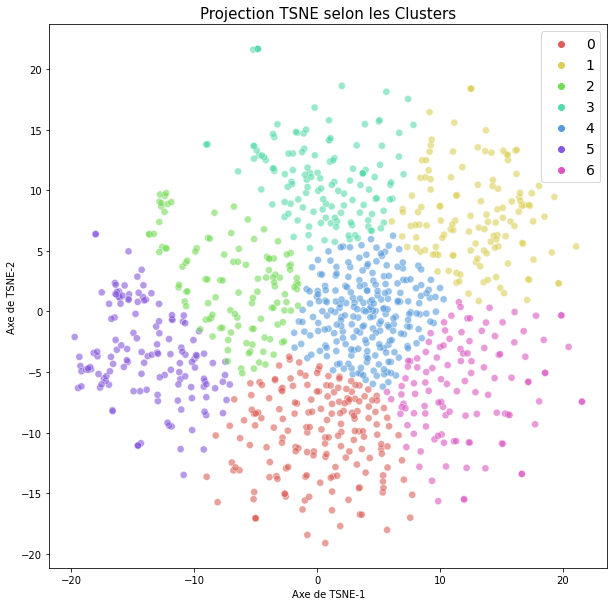

In [91]:
plt.figure(figsize=(10,10))
sns.scatterplot(x="TSNE-1", y="TSNE-2", hue="Cluster", data=df_tsne, legend="brief",  s=50, alpha=0.6, palette=sns.color_palette('hls', n_colors=7))

plt.title('Projection TSNE selon les Clusters', fontsize = 15)
plt.xlabel('Axe de TSNE-1', fontsize = 10)
plt.ylabel('Axe de TSNE-2', fontsize = 10)
plt.legend(prop={'size': 14})

# plt.ylim(-15, 15)
# plt.xlim(-15, 15)

plt.show()

In [92]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels = le.fit_transform(df_Pict["Category"])
labels

array([4, 0, 0, ..., 0, 0, 0])

In [93]:
labels = df_Pict["Category"]
print("ARI : ", metrics.adjusted_rand_score(labels, Clusters.labels_))

ARI :  0.0013292756343382028


In [94]:
labels.shape

(1050,)

In [95]:
ARI_score= metrics.adjusted_rand_score(labels, Clusters.labels_)

In [96]:
Silh_score = silhouette_score(X_tsne, Clusters.labels_)  
ARI_score= metrics.adjusted_rand_score(labels, Clusters.labels_)
AMI_score= metrics.adjusted_mutual_info_score(labels, Clusters.labels_) 
Homg_score= metrics.homogeneity_score(labels, Clusters.labels_)
Comp_score= metrics.completeness_score(labels, Clusters.labels_)
V_mesure_score= metrics.v_measure_score(labels, Clusters.labels_)
Calinski_score= metrics.calinski_harabasz_score(X_tsne, labels)

In [97]:
# Score de silhouette : information sur la séparation des clusters, la valeur 0 0 indique que les clusters qui se chevauchent
print("la silhouette",Silh_score) 

# ARI score : calcule une mesure de similarité entre deux clusters prédit et vrai, la valeur 1 indique que les clusters sont identiques 
print("le score ARI",ARI_score)

# AMI score : est un ajustement du score d'information mutuelle (MI) pour tenir compte du hasard entre deux clusters.
print("le score AMI",AMI_score)

# le score homogenité : Son retour le score entre 0.0 et 1.0 signifie un étiquetage parfaitement homogène.
print("le score homogenité",Homg_score)

# le score complétude : décrit la proximité de l'algorithme de clustering avec cette perfection, tous les membres d'une classe donnée sont affectés au même cluster.
print("le score complétude",Comp_score)

# le V_mesure : La mesure V est la moyenne harmonique entre l'homogénéité et la complétude
print("le V_mesure",V_mesure_score)

# le score Calinski : C'est le rapport entre la variance inter-clusters et la variance intra-clusters
print("le score Calinski",Calinski_score)

la silhouette 0.36292616
le score ARI 0.0013292756343382028
le score AMI 0.002725625410647242
le score homogenité 0.011588770653386146
le score complétude 0.011767806214571883
le V_mesure 0.01167760225183104
le score Calinski 1.4383828163519177


**Interprétation**

- Le score ARI est trop faible (0.0013).
- Cette combinaison TSNE SIFT sur les images ne parvient pas à retrouver les 7 catégories comme le souhaite notre client